In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorboard

In [2]:
batch_size = 64
img_size = 64
num_channels = 3
z_dim = 100
features_gen = 64
features_disc = 64
lr = 2.0e-4
alpha = 0.2
num_epochs = 100
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda:1


In [4]:
transform = transforms.Compose([
    transforms.Resize([img_size, img_size]),
    transforms.ToTensor(),
    transforms.Normalize(
    [0.5 for _ in range(num_channels)], [0.5 for _ in range(num_channels)])
])

In [5]:
# data_dir = 'DATASETS/celeba/images' # CELEBA IMAGES
# data_dir = 'DATASETS/flowers/all_images' # FLOWERS IMAGES
# data_dir = 'DATASETS/cats_and_dogs/all_images' # CATS AND DOGS IMAGES
data_dir = 'DATASETS/anime_faces' # ANIME FACES IMAGES
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)

In [6]:
images, labels = next(iter(dataloader))
np.shape(images)

torch.Size([64, 3, 64, 64])

In [7]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim, features_gen, num_channels):
        super().__init__()
        self.z_dim = z_dim
        self.features_gen = features_gen
        self.num_channels = num_channels
        
        self.net = nn.Sequential(
            self._block(in_channels=z_dim, out_channels=features_gen*16, kernel_size=4, stride=1, padding=0),
            self._block(features_gen*16, features_gen*8, 4, 2, 1),
            self._block(features_gen*8, features_gen*4, 4, 2, 1),
            self._block(features_gen*4, features_gen*2, 4, 2, 1),
            nn.ConvTranspose2d(features_gen*2, num_channels, 4, 2, 1),
            nn.Tanh())
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)
    

In [9]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, features_disc, num_channels, alpha):
        super().__init__()
        self.z_dim = z_dim
        self.features_disc = features_disc
        self.num_channels = num_channels
        self.alpha = alpha
        
        
        self.net = nn.Sequential(
                self._block(num_channels, features_disc*2, 4, 2, 1),
                self._block(features_disc*2, features_disc*4, 4, 2, 1),
                self._block(features_disc*4, features_disc*8, 4, 2, 1),
                self._block(features_disc*8, features_disc*16, 4, 2, 1),
                nn.Conv2d(features_disc*16, 1, 4, 2, 0),
                nn.Sigmoid()       
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(alpha)
        )
    
    def forward(self, x):
        return self.net(x).reshape(-1, 1)

In [10]:
gen = Generator(z_dim, features_gen,  num_channels).to(device)
disc = Discriminator(z_dim, features_disc, num_channels, alpha).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [11]:
gen_optim = optim.Adam(params=gen.parameters(), lr = lr, betas=(0.5, 0.999))
disc_optim = optim.Adam(params=disc.parameters(), lr = lr, betas=(0.5, 0.999))
criterion = criterion = nn.BCELoss().to(device)
fixed_noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
real_targets = torch.ones(batch_size, 1).to(device)
fake_targets = torch.zeros(batch_size, 1).to(device)

In [12]:
# To save images in grid layout
def save_image_grid(epoch: int, images: torch.Tensor, ncol: int):
    
    image_grid = make_grid(images, ncol, normalize=True)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
#     plt.savefig(f'generated_images/dcgan_celeba/generated_{epoch+1:03d}.jpg') # CELEBA GENERATED IMAGES
#     plt.savefig(f'generated_images/cats_and_dogs/generated_{epoch+1:03d}.jpg') # CATS AND DOGS GENERATED IMAGES
    plt.savefig(f'generated_images/anime_faces/generated_{epoch+1:03d}.jpg') # ANIME FACES GENERATED IMAGES
    plt.close()

In [ ]:
for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    for images, _ in tqdm(dataloader):
        images = images.to(device)
        
        # TRAINING DISCRIMINATOR
        disc.train()
        disc_optim.zero_grad()
        disc_real_out = disc(images)
        disc_real_loss = criterion(disc_real_out, real_targets)
        
        gen.eval()
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        disc_fake_out = disc(gen(noise))
        disc_fake_loss = criterion(disc_fake_out, fake_targets)
        
        # Total loss
        d_loss = disc_real_loss + disc_fake_loss
        
        # Backprop and Update params
        d_loss.backward()
        disc_optim.step()
        
        # Training Generator
        gen.train()
        gen_optim.zero_grad()
        fake_images = gen(noise)
        g_loss = criterion(disc(fake_images), real_targets)
        
        # Backprop and Update params
        g_loss.backward()
        gen_optim.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    print(f'EPOCH: {epoch+1} | G_LOSS: {np.mean(g_losses):.3f} | D_LOSS: {np.mean(d_losses):.3f}')
    
    gen.eval()
    generated_images = gen(fixed_noise)
    save_image_grid(epoch, generated_images, 8)

100%|██████████| 993/993 [01:39<00:00,  9.96it/s]


EPOCH: 1 | G_LOSS: 2.719 | D_LOSS: 0.687


100%|██████████| 993/993 [01:37<00:00, 10.19it/s]


EPOCH: 2 | G_LOSS: 3.284 | D_LOSS: 0.709


100%|██████████| 993/993 [01:37<00:00, 10.20it/s]


EPOCH: 3 | G_LOSS: 3.670 | D_LOSS: 0.572


100%|██████████| 993/993 [01:37<00:00, 10.17it/s]


EPOCH: 4 | G_LOSS: 3.877 | D_LOSS: 0.480


100%|██████████| 993/993 [01:37<00:00, 10.14it/s]


EPOCH: 5 | G_LOSS: 3.771 | D_LOSS: 0.470


100%|██████████| 993/993 [01:38<00:00, 10.09it/s]


EPOCH: 6 | G_LOSS: 3.938 | D_LOSS: 0.427


100%|██████████| 993/993 [01:38<00:00, 10.07it/s]


EPOCH: 7 | G_LOSS: 3.976 | D_LOSS: 0.412


100%|██████████| 993/993 [01:37<00:00, 10.15it/s]


EPOCH: 8 | G_LOSS: 4.269 | D_LOSS: 0.365


100%|██████████| 993/993 [01:37<00:00, 10.13it/s]


EPOCH: 9 | G_LOSS: 4.426 | D_LOSS: 0.346


100%|██████████| 993/993 [01:37<00:00, 10.17it/s]


EPOCH: 10 | G_LOSS: 4.553 | D_LOSS: 0.334


100%|██████████| 993/993 [01:38<00:00, 10.11it/s]


EPOCH: 11 | G_LOSS: 4.653 | D_LOSS: 0.333


100%|██████████| 993/993 [01:38<00:00, 10.10it/s]


EPOCH: 12 | G_LOSS: 4.841 | D_LOSS: 0.290


100%|██████████| 993/993 [01:38<00:00, 10.07it/s]


EPOCH: 13 | G_LOSS: 5.061 | D_LOSS: 0.285


100%|██████████| 993/993 [01:38<00:00, 10.10it/s]


EPOCH: 14 | G_LOSS: 4.989 | D_LOSS: 0.293


100%|██████████| 993/993 [01:38<00:00, 10.05it/s]


EPOCH: 15 | G_LOSS: 5.022 | D_LOSS: 0.291


100%|██████████| 993/993 [01:38<00:00, 10.12it/s]


EPOCH: 16 | G_LOSS: 5.015 | D_LOSS: 0.261


100%|██████████| 993/993 [01:38<00:00, 10.13it/s]


EPOCH: 17 | G_LOSS: 5.060 | D_LOSS: 0.261


100%|██████████| 993/993 [01:38<00:00, 10.11it/s]


EPOCH: 18 | G_LOSS: 5.261 | D_LOSS: 0.246


100%|██████████| 993/993 [01:38<00:00, 10.09it/s]


EPOCH: 19 | G_LOSS: 5.482 | D_LOSS: 0.214


100%|██████████| 993/993 [01:38<00:00, 10.10it/s]


EPOCH: 20 | G_LOSS: 5.342 | D_LOSS: 0.239


100%|██████████| 993/993 [01:38<00:00, 10.10it/s]


EPOCH: 21 | G_LOSS: 5.361 | D_LOSS: 0.213


100%|██████████| 993/993 [01:38<00:00, 10.09it/s]


EPOCH: 22 | G_LOSS: 5.421 | D_LOSS: 0.216


100%|██████████| 993/993 [01:38<00:00, 10.05it/s]


EPOCH: 23 | G_LOSS: 5.403 | D_LOSS: 0.233


100%|██████████| 993/993 [01:38<00:00, 10.11it/s]


EPOCH: 24 | G_LOSS: 5.239 | D_LOSS: 0.219


100%|██████████| 993/993 [01:38<00:00, 10.09it/s]


EPOCH: 25 | G_LOSS: 5.280 | D_LOSS: 0.219


100%|██████████| 993/993 [01:26<00:00, 11.44it/s]


EPOCH: 26 | G_LOSS: 5.359 | D_LOSS: 0.219


100%|██████████| 993/993 [01:25<00:00, 11.63it/s]


EPOCH: 27 | G_LOSS: 5.346 | D_LOSS: 0.199


100%|██████████| 993/993 [01:32<00:00, 10.68it/s]


EPOCH: 28 | G_LOSS: 5.478 | D_LOSS: 0.151


100%|██████████| 993/993 [01:40<00:00,  9.84it/s]


EPOCH: 29 | G_LOSS: 5.277 | D_LOSS: 0.275


100%|██████████| 993/993 [01:52<00:00,  8.86it/s]


EPOCH: 30 | G_LOSS: 5.338 | D_LOSS: 0.184


100%|██████████| 993/993 [01:52<00:00,  8.85it/s]


EPOCH: 31 | G_LOSS: 5.478 | D_LOSS: 0.223


100%|██████████| 993/993 [01:51<00:00,  8.88it/s]


EPOCH: 32 | G_LOSS: 5.500 | D_LOSS: 0.165


100%|██████████| 993/993 [01:52<00:00,  8.86it/s]


EPOCH: 33 | G_LOSS: 5.583 | D_LOSS: 0.214


100%|██████████| 993/993 [01:52<00:00,  8.87it/s]


EPOCH: 34 | G_LOSS: 5.497 | D_LOSS: 0.193


100%|██████████| 993/993 [01:52<00:00,  8.86it/s]


EPOCH: 35 | G_LOSS: 5.566 | D_LOSS: 0.167


100%|██████████| 993/993 [01:51<00:00,  8.87it/s]


EPOCH: 36 | G_LOSS: 5.610 | D_LOSS: 0.176


100%|██████████| 993/993 [01:51<00:00,  8.89it/s]


EPOCH: 37 | G_LOSS: 5.716 | D_LOSS: 0.161


100%|██████████| 993/993 [01:51<00:00,  8.90it/s]


EPOCH: 38 | G_LOSS: 5.578 | D_LOSS: 0.180


100%|██████████| 993/993 [01:51<00:00,  8.89it/s]


EPOCH: 39 | G_LOSS: 5.758 | D_LOSS: 0.171


100%|██████████| 993/993 [01:52<00:00,  8.86it/s]


EPOCH: 40 | G_LOSS: 5.730 | D_LOSS: 0.171


100%|██████████| 993/993 [01:52<00:00,  8.86it/s]


EPOCH: 41 | G_LOSS: 5.847 | D_LOSS: 0.134


100%|██████████| 993/993 [01:51<00:00,  8.88it/s]


EPOCH: 42 | G_LOSS: 5.691 | D_LOSS: 0.180


 75%|███████▌  | 747/993 [01:24<00:28,  8.55it/s]

In [30]:
def show_image_grid(images: torch.Tensor, ncol: int):
    
    image_grid = make_grid(images, ncol, normalize=True)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy
    plt.figure(figsize = (8, 4))
    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
#     plt.close()

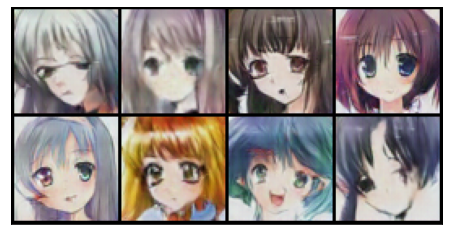

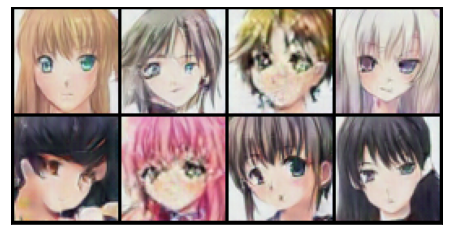

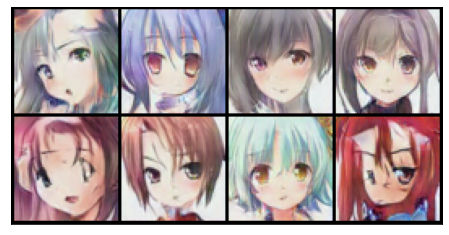

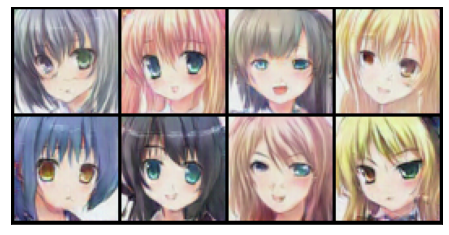

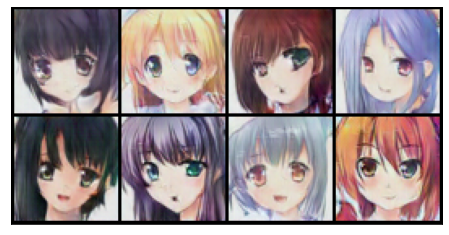

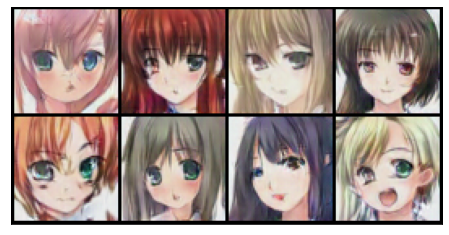

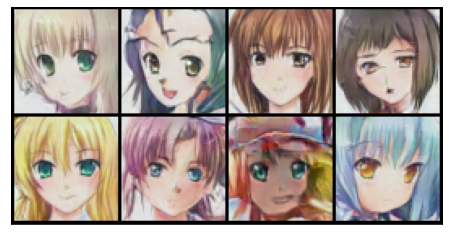

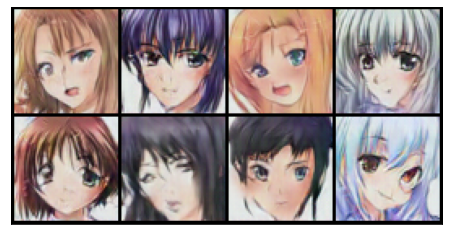

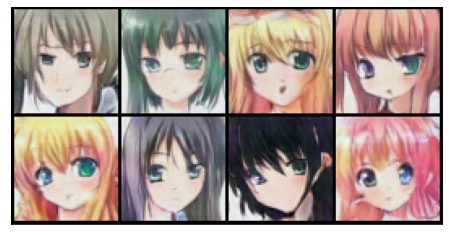

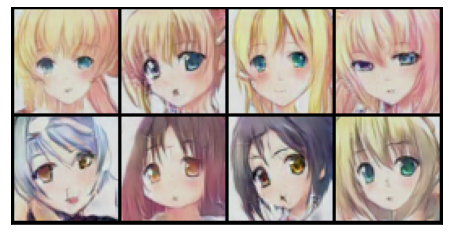

In [33]:
for i in range(10):
    gen.eval()
    noise = torch.randn(8, 100, 1, 1).to(device)
    gen_images = gen(noise)
    show_image_grid(gen_images, 4)